# Matching Cut Implementation

This python notebook consists of the implementation of FPT kernelisation algorithm mentioned in the paper<br>[*Komusiewicz, Christian & Kratsch, Dieter & Le, Van Bang. (2019). Matching Cut: Kernelization, Single-Exponential Time FPT, and Exact Exponential Algorithms. Discrete Applied Mathematics. 283. 10.1016/j.dam.2019.12.010.*](https://drops.dagstuhl.de/opus/volltexte/2019/10220/pdf/LIPIcs-IPEC-2018-19.pdf)<br>
We are dividing the implementation into 4 different parts - the graph specific functionalities, functions that support the matching cut problem and finally the kernel class that contains the functions to run the kernelisation algorithm. This is followed by outputs from the testcases ran. The testcases are available [here](https://drive.google.com/drive/folders/1sojbaOGuOrXuOJmeJ4WcAYFs4n2ol4Si?usp=sharing)<br>
Each of these sections can be accessed through the Table of Contents in the left tab.

## Libraries/Modules
We start with the libraries we are going to use for various operations<br>
***networkx*** provides support to visualise the graph we feed to it<br>
***matplotlib*** provide support for plotting which combined with networkx gives us the visualisation we need<br>
***copy*** provides a tool deepcopy to create a copy of even a user defined data structure

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
import copy

## Graph Defintion and Functionalities

We continue with defining how our graph is implemented as code followed by the methods to manipulate(add/delete) and get subgraphs from it <br><br>
Usage of the functions:<br>
`restoreGraph()` -> replaces the existing graph with a backup created when the graph was generated <br>
`visualise()` -> generates a plot of the graph to visualise, using networkx <br>
`deleteNodes(nodeList)` -> delete a list of nodes from the graph <br>
`deleteEdges(edgeList)` -> delete a list of edges from the graph <br>
`addEdges(edgeList)` -> add a list of edges to the graph <br>
`generateGraph(txt)` -> takes a string of a textfile name to generate a graph. The graph requires a specific formatting: the first line contains an integer providing the number of nodes in our graph, the following lines contains a pair of labels of the nodes providing information about edges between these 2 nodes <br>
`generateFile(txt)` -> takes a string of textfile name to generate a file based on the format mentioned above. Default generate file name is set as genFile.txt<br>
`getComponent(node)` -> takes a node to return the tree in the graph forest containing that node <br>
`findClusters()` -> returns all the trees in the graph forest

In [21]:
class Graph:
  def __init__(self, graph):
    self.graph = graph if type(graph) is dict else {}
    if type(graph) is str:
      self.generateGraph(graph)
    self.__backup = copy.deepcopy(self.graph)

  def restoreGraph(self):
    self.graph = copy.deepcopy(self.__backup)
  
  def visualise(self):
    self.V = self.graph.keys()
    self.E = set()
    for u in self.V:
      for v in self.graph[u]:
        self.E.add((u, v))
    self.__nxG = nx.Graph()
    self.__nxG.add_edges_from(list(self.E))
    nx.draw_networkx(self.__nxG)
    plt.show()

  def deleteNodes(self, nodeList):
    for u in nodeList:
      if u in self.graph.keys():
        self.deleteEdges(list(map(lambda x: (u, x), self.graph[u])))
        self.graph.pop(u)

  def deleteEdges(self, edgeList):
    for (u, v) in edgeList:
      self.graph[u].remove(v)
      self.graph[v].remove(u)
  
  def addEdges(self, edgeList):
    for (u, v) in edgeList:
      if u in self.graph.keys() and v in self.graph.keys():
        self.graph[u].add(v)
        self.graph[v].add(u)
  
  def generateGraph(self, txt = "graphExample1.txt"):
    with open(txt) as f:
      for line in f:
        if not self.graph.keys():
          for i in range(int(line)):
            self.graph[i] = set()
        else:
          u,v = map(int, line.split())
          self.graph[u].add(v)
          self.graph[v].add(u)
  
  def generateFile(self, txt = "genFile.txt"):
    edgeSet = set()
    for u in self.graph.keys():
      for v in self.graph[u]:
        edgeSet.add((u, v))
    removeset = []
    for e1 in edgeSet:
      for e2 in edgeSet:
        if e1 != e2 and set(e1) == set(e2) and e1 not in removeset:
          removeset.append(e2)
    for edge in removeset:
      edgeSet.remove(edge)
    with open("genFile.txt", 'w') as f:
      for edge in edgeSet:
        f.write(str(edge[0]) + " " + str(edge[1]) + "\n")

  def getComponent(self, visited = None, node = None):
    if visited == None:
      visited = set()
    if node == None:
      node = list(self.graph.keys())[0]
    vertexList = [node]
    component = set([node])
    while vertexList:
      current = vertexList.pop(0)
      for v in self.graph[current]:
        if v not in visited:
          visited.add(v)
          component.add(v)
          vertexList.append(v)
    return component

  def findClusters(self):
    visited = set()
    nodesLeft = list(self.graph.keys())
    components = []
    while nodesLeft:
      node = nodesLeft.pop(-1)
      if node not in visited:
        components.append(self.getComponent(visited, node))
    return components

We run a test of the graph class by generating through [csacademy.com/app/graph_editor](https://csacademy.com/app/graph_editor/)

{0: {1, 6}, 1: {0, 10, 2}, 2: {1, 3, 12, 13}, 3: {2, 4, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 11: {12, 13}, 12: {2, 11, 13}, 13: {2, 11, 12}, 14: {3, 15}, 15: {3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}}


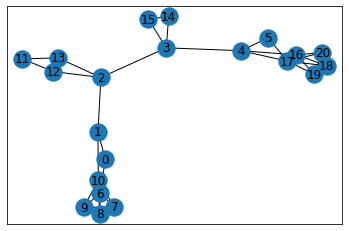

In [22]:
G = Graph("graphExample1.txt") # Use https://csacademy.com/app/graph_editor/ to generate data for a specific graph
print(G.graph)
G.visualise()

## Functions for Matching Cut

We have 3 functions:<br>
`cluster3fApprox(G)` -> Generates a 3 factor approximation of cluster vertex deletion problem <br>
`isCut(G, M)` -> checks if a given edge set M is a cut <br>
`isMatchingCut(G, C)` -> Given a vertex set, we check if that and the remaining graph can form a partition such that the set of edges between them is a matching cut <br>
`matchingCut(G, M, V)` -> Recursively applies a bruteforce to find if there is a matching cut in the graph

In [23]:
def cluster3fApprox(G):
  graph = G.graph
  delList = []
  for u in graph.keys():
    for v in graph[u]:
      for w in graph[v]:
        if w not in graph[u] and w != u:
          if [u] not in delList and [v] not in delList and [w] not in delList:
            delList += [[u], [v], [w]]
            break
  return delList

In [24]:
cluster3fApprox(G)

[[0], [1], [10], [2], [3], [4], [5], [17], [16]]

In [25]:
def isCut(G, M):
  G.deleteEdges(M)
  graph = G.graph
  visited = set()
  start = list(graph.keys())[0]
  vertexList = [start]
  stop = False
  while not stop:
    current = vertexList.pop(0)
    for v in graph[current]:
      if v not in visited:
        visited.add(v)
        vertexList.append(v)
    if not vertexList:
      stop = True
  G.addEdges(M)
  if len(visited) == len(graph.keys()):
    return False
  return True

In [26]:
def isMatchingCut(G, C):
  M = []
  V = set()
  for u in C:
    for v in G.graph[u]:
      if v not in C:
        M.append((u, v))
        if u in V or v in V:
          return False
        V.add(u)
        V.add(v)
  return isCut(G, M)

In [27]:
def matchingCut(G, M, V):
  if isCut(G, M):
    return True
  for edge in G.E:
    if edge[0] not in V and edge[1] not in V:
      if matchingCut(G, M + [edge], V + list(edge)):
        return True
  return False

In [28]:
print(matchingCut(G, [], []))

True


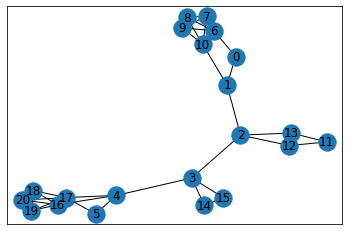

None


In [29]:
print(G.visualise())

## Kernelisation Algorithm

The class matchingCutKernel consists of functions to calculate the kernel of the problem <br>
It has 8 functions for the rules defined in the report and the paper. <br> We also define a `n2()` function to calculate the N2 of each vertices in U <br> The `checkRules()` checks the rules in sequence and return True for the first True returned. This supports the kernelisation method required.  <br>
`getKernel()` runs the rules in sequence untill it can no longer reduce the graph. It also visualises the rules passed indicating if a rule is applied and a visualisaton of the graph and the clusters are plotted.

In [30]:
class matchingCutKernel:
  def __init__(self, G, U):
    self.G = G
    self.w = Graph(copy.deepcopy(G.graph))
    for u in U:
      self.w.deleteNodes(u)
    self.U = U
    self.clusters = self.w.findClusters()
    self.Uset = set([item for sublist in self.U for item in sublist])
    self.N2 = {}

  def n2(self):
    N2 = {}
    for i, Ui in list(enumerate(self.U)):
      N2[i] = set()
      # Case 1: v has 2 neighbours in Ui
      for ui in Ui:
        for v in self.G.graph[ui]:
          for vi in self.G.graph[v]:
            if vi in Ui and vi != ui and v not in self.Uset:
              N2[i].add(v)

      # Case 2: v is in a cluster of size at least 3 in G - U that contains a vertex that has 2 neighbours in Ui
      for cluster in self.clusters:
        if len(cluster) >= 3:
          for v in cluster:
            if v in N2[i]:
              for w in cluster:
                  N2[i].add(w)

      # Case 3: V is in a cluster C in G - U and some vertex in Ui has 2 neighbours in C.
      for cluster in self.clusters:
        for u in cluster:
          for ui in self.G.graph[u]:
            for w in self.G.graph[ui]:
              if ui in Ui and w in cluster and w != u:
                for x in cluster:
                  N2[i].add(x)
    return N2

  def rule1(self):
    print("Rule1")
    for cluster in self.clusters:
      if isMatchingCut(self.G, cluster):
        return True, cluster
    for v in self.G.graph.keys():
      if len(self.G.graph[v]) <= 1:
        return True, v
    return False

  def rule2(self):
    print("Rule2")
    merge = {}
    for ui in self.N2.keys():
      for uj in self.N2.keys():
        if self.N2[ui].intersection(self.N2[uj]) and ui != uj:
          if ui not in merge.keys():
            merge[ui] = set()
          merge[ui].add(uj)
    if not merge: # If there is no sets available to merge: return False
      return False
    mergesets = Graph(merge).findClusters()
    removeset = []
    for x in mergesets:
      newset = []
      for y in x:
        newset = newset + self.U[y]
        removeset.append(self.U[y])
      self.U.append(newset)
    for x in removeset:
      self.U.remove(x)
    return True

  def rule3(self):
    print("Rule3")
    merge = {}
    for i, ui in list(enumerate(self.U)):
      for j, vi in list(enumerate(self.U)):
        if ui != vi:
          for u in ui:
            for v in vi:
              uneighbours = set(self.G.graph[u])
              vneighbours = set(self.G.graph[v])
              if len(uneighbours.intersection(vneighbours)) > 2 and u != v:
                if i not in merge.keys():
                  merge[i] = set()
                merge[i].add(j)
    if not merge: # If there is no sets available to merge: return False
        return False
    mergesets = Graph(merge).findClusters()
    removeset = []
    for x in mergesets:
      newset = []
      for y in x:
        newset = newset + self.U[y]
        removeset.append(self.U[y])
      self.U.append(newset)
    for x in removeset:
      self.U.remove(x)
    return True

  def rule4(self):
    print("Rule4")
    merge = {}
    for i in self.N2.keys():
      for u in self.N2[i]:
        for v in self.N2[i]:
          ucluster = vcluster = -1
          for j, cluster in list(enumerate(self.clusters)):
            if u in cluster:
              ucluster = j
            if v in cluster:
              vcluster = j
          if ucluster != vcluster and ucluster != -1 and vcluster != -1:
            if ucluster not in merge.keys():
              merge[ucluster] = set()
            merge[ucluster].add(vcluster)
    if not merge: # If no 2 such clusters exist, return False
      return False
    mergeset = Graph(merge).findClusters()
    removeset = []
    for x in mergeset:
      newset = set()
      for y in x:
        newset = newset.union(self.clusters[y])
        removeset.append(self.clusters[y])
      for u in newset:
        for v in newset:
          if v not in self.G.graph[u] and v != u:
            self.G.graph[u].add(v)
            self.w.graph[u].add(v)
    return True
  
  def rule5(self):
    print("Rule5")
    removeset = set()
    for cluster in self.clusters:
      for u in cluster:
        if len(set(self.G.graph[u]).intersection(self.Uset)) == 0:
          removeset.add(u)
    if not removeset:
      return False
    self.G.deleteNodes(removeset)
    self.w.deleteNodes(removeset)
    return True

  def rule6(self):
    print("Rule6")
    deleteSet = []
    temp = []
    addSet = set()
    for i, Ui in list(enumerate(self.U)):
      for cluster in self.clusters:
        if set(cluster).intersection(set(self.N2[i])) and len(cluster) > 2:
          temp = []
          for u in cluster:
            for v in self.G.graph[u]:
              if v in Ui:
                temp.append((u, v))
          if len(temp) == 2 and temp[0][1] == temp[1][1]:
            break
          if len(temp) == 3 and len(Ui) == 2 and len(set([y[1] for y in temp])) == 2:
            break
          itervar = iter(cluster)
          addSet.add((next(itervar), Ui[0]))
          addSet.add((next(itervar), Ui[0]))
          if len(Ui) == 2:
            addSet.add((next(itervar), Ui[1]))
          deleteSet += temp
      if len(Ui) > 2:
        for u in Ui:
          for v in Ui:
            if v not in self.G.graph[u]:
              addSet.add((u, v))
    if not deleteSet and not addSet:
      return False    
    self.G.deleteEdges(deleteSet)
    self.G.addEdges(addSet)
    return True

  def rule7(self):
    print("Rule7")
    n1 = n2 = -1
    for cluster in self.clusters:
      if len(cluster) == 2:
        itervar = iter(cluster)
        u1 = next(itervar)
        n1 = -1
        u2 = next(itervar)
        n2 = -1
        for i, ui in list(enumerate(self.U)):
          for v in ui:
            if v in self.G.graph[u1]:
              if n1 != -1 and n1 != i:
                n1 = -2
              else:
                n1 = i
            if v in self.G.graph[u2]:
              if n2 != -1 and n2 != i:
                n2 = -2
              else:
                n2 = i
    if n1 < 0 or n2 < 0 or n1 == n2:
      return False
    self.G.deleteNodes([u1, u2])
    self.w.deleteNodes([u1, u2])
    return True
  
  def rule8(self):
    print("Rule8")
    clusterIndex = {}
    uindex = {}
    for i, ui in list(enumerate(self.U)):
      for u in ui:
        uindex[u] = i
    for i, cluster in list(enumerate(self.clusters)):
      for u in cluster:
        clusterIndex[u] = i
    nclusterIndex = {}
    for Ui in self.U:
      for u in Ui:
        for v in self.G.graph[u]:
          if v not in self.Uset:
            if u not in nclusterIndex.keys():
              nclusterIndex[u] = set()
            nclusterIndex[u].add(clusterIndex[v])
    merge = {}
    for u in nclusterIndex.keys():
      for v in nclusterIndex.keys():
        if len(nclusterIndex[u].intersection(nclusterIndex[v])) > 2 and uindex[u] != uindex[v]:
          if uindex[u] not in merge.keys():
            merge[uindex[u]] = set()
          merge[uindex[u]].add(uindex[v])
    if not merge: # If there is no sets available to merge: return False
      return False
    mergesets = Graph(merge).findClusters()
    removeset = []
    for x in mergesets:
      newset = []
      for y in x:
        newset = newset + self.U[y]
        removeset.append(self.U[y])
      self.U.append(newset)
    for x in removeset:
      self.U.remove(x)
    return True
    
  def getKernel(self):
    self.clusters = self.w.findClusters()
    self.Uset = set([item for sublist in self.U for item in sublist])
    self.N2 = self.n2()
    if self.rule1():
      return True
    print(self.G.graph)
    while self.checkRules():
      print(self.G.graph)
      print("Inside While")
      self.G.visualise()
      self.w.visualise()
      self.clusters = self.w.findClusters()
      self.Uset = set([item for sublist in self.U for item in sublist])
      self.N2 = self.n2()
    print(self.G.graph)
    return self.G.graph

  def checkRules(self):
    return self.rule2() or self.rule3() or self.rule4() or self.rule5() or self.rule6() or self.rule7() or self.rule8()

## Test Cases

In [31]:
G1 = Graph("graphExample1.txt")
mc1 = matchingCutKernel(G1, cluster3fApprox(G1))

In [32]:
mc1.U

[[0], [1], [10], [2], [3], [4], [5], [17], [16]]

Rule1
{0: {1, 6}, 1: {0, 10, 2}, 2: {1, 3, 12, 13}, 3: {2, 4, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 11: {12, 13}, 12: {2, 11, 13}, 13: {2, 11, 12}, 14: {3, 15}, 15: {3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}}
Rule2
{0: {1, 6}, 1: {0, 10, 2}, 2: {1, 3, 12, 13}, 3: {2, 4, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 11: {12, 13}, 12: {2, 11, 13}, 13: {2, 11, 12}, 14: {3, 15}, 15: {3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}}
Inside While


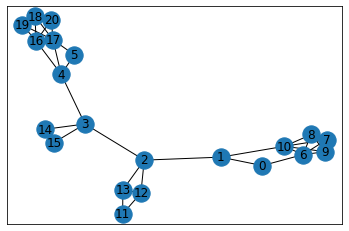

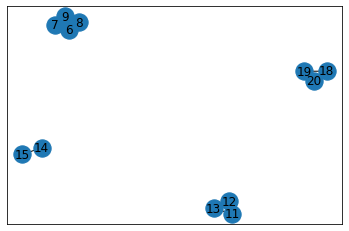

Rule2
Rule3
Rule4
Rule5
{0: {1, 6}, 1: {0, 10, 2}, 2: {1, 3, 12, 13}, 3: {2, 4, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 12: {2, 13}, 13: {2, 12}, 14: {3, 15}, 15: {3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}}
Inside While


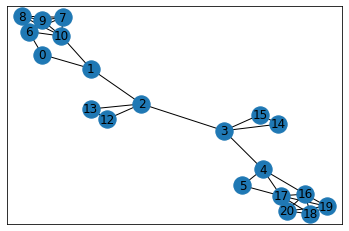

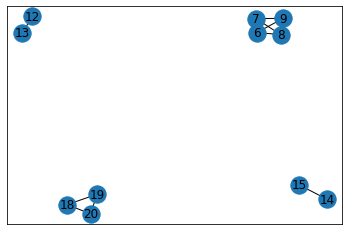

Rule2
Rule3
Rule4
Rule5
Rule6
{0: {1, 6}, 1: {0, 10, 2}, 2: {1, 3, 12, 13}, 3: {2, 4, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 7, 8, 9}, 7: {8, 9, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 8, 9}, 12: {2, 13}, 13: {2, 12}, 14: {3, 15}, 15: {3, 14}, 16: {4, 17, 18, 19}, 17: {4, 5, 16, 20}, 18: {16, 19, 20}, 19: {16, 18, 20}, 20: {17, 18, 19}}
Inside While


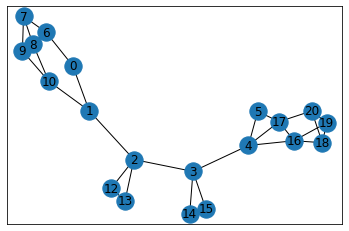

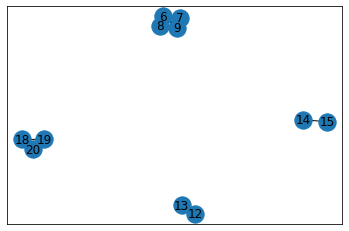

Rule2
Rule3
Rule4
Rule5
{0: {1, 6}, 1: {0, 10, 2}, 2: {1, 3, 12, 13}, 3: {2, 4, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 8, 9}, 8: {9, 10, 6}, 9: {8, 10, 6}, 10: {1, 8, 9}, 12: {2, 13}, 13: {2, 12}, 14: {3, 15}, 15: {3, 14}, 16: {4, 17, 18, 19}, 17: {4, 5, 16, 20}, 18: {16, 19, 20}, 19: {16, 18, 20}, 20: {17, 18, 19}}
Inside While


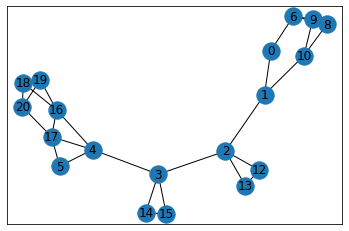

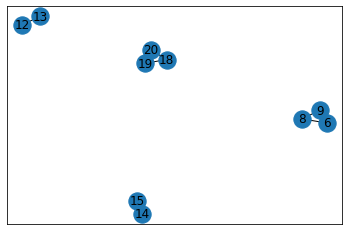

Rule2
Rule3
Rule4
Rule5
Rule6
Rule7
Rule8
{0: {1, 6}, 1: {0, 10, 2}, 2: {1, 3, 12, 13}, 3: {2, 4, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 8, 9}, 8: {9, 10, 6}, 9: {8, 10, 6}, 10: {1, 8, 9}, 12: {2, 13}, 13: {2, 12}, 14: {3, 15}, 15: {3, 14}, 16: {4, 17, 18, 19}, 17: {4, 5, 16, 20}, 18: {16, 19, 20}, 19: {16, 18, 20}, 20: {17, 18, 19}}


{0: {1, 6},
 1: {0, 2, 10},
 2: {1, 3, 12, 13},
 3: {2, 4, 14, 15},
 4: {3, 5, 16, 17},
 5: {4, 17},
 6: {0, 8, 9},
 8: {6, 9, 10},
 9: {6, 8, 10},
 10: {1, 8, 9},
 12: {2, 13},
 13: {2, 12},
 14: {3, 15},
 15: {3, 14},
 16: {4, 17, 18, 19},
 17: {4, 5, 16, 20},
 18: {16, 19, 20},
 19: {16, 18, 20},
 20: {17, 18, 19}}

In [33]:
mc1.getKernel()

In [34]:
mc1.N2

{0: set(),
 1: set(),
 2: {6, 8, 9},
 3: {12, 13},
 4: {14, 15},
 5: set(),
 6: set(),
 7: {18, 19, 20}}

In [35]:
G2 = Graph("graphExample2.txt")
mc2 = matchingCutKernel(G2, cluster3fApprox(G2))

In [36]:
mc2.U

[[0], [2], [3]]

In [37]:
mc2.getKernel()

Rule1


True

In [38]:
mc2.N2

{0: {1, 4, 5}, 1: {1, 4, 5}, 2: {13, 14, 15, 16}}

In [39]:
G3 = Graph("graphExample3.txt")
mc3 = matchingCutKernel(G3, cluster3fApprox(G3))

In [40]:
mc3.U

[[0], [2], [3]]

In [41]:
mc3.getKernel()

Rule1


True

In [42]:
mc3.N2

{0: {1, 4, 5}, 1: {1, 4, 5}, 2: {6, 7, 8, 14, 15}}

In [43]:
G4 = Graph("graphExample4.txt")
mc4 = matchingCutKernel(G4, cluster3fApprox(G4))

In [44]:
mc4.U

[[0], [1], [10], [2], [3], [4], [5], [17], [16]]

Rule1
{0: {1, 6}, 1: {0, 10, 2}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15, 21}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 11: {12, 13}, 12: {2, 11, 13}, 13: {3, 2, 11, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 3}}
Rule2
{0: {1, 6}, 1: {0, 10, 2}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15, 21}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 11: {12, 13}, 12: {2, 11, 13}, 13: {3, 2, 11, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 3}}
Inside While


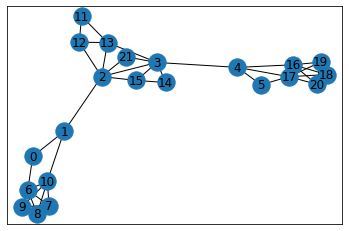

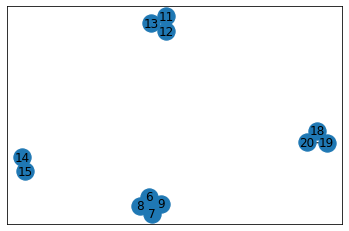

Rule2
Rule3
{0: {1, 6}, 1: {0, 10, 2}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15, 21}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 11: {12, 13}, 12: {2, 11, 13}, 13: {3, 2, 11, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 3}}
Inside While


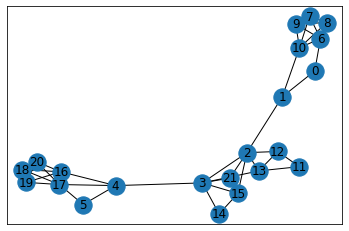

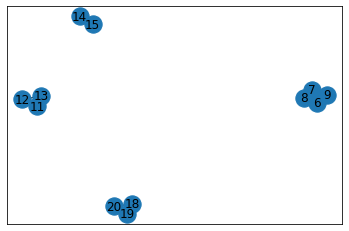

Rule2
Rule3
Rule4
{0: {1, 6}, 1: {0, 10, 2}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15, 21}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 11: {12, 13, 14, 15, 21}, 12: {2, 11, 13, 14, 15, 21}, 13: {2, 3, 11, 12, 14, 15, 21}, 14: {3, 11, 12, 13, 15, 21}, 15: {2, 3, 11, 12, 13, 14, 21}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 3, 11, 12, 13, 14, 15}}
Inside While


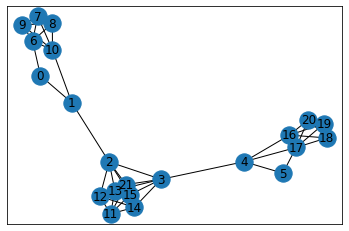

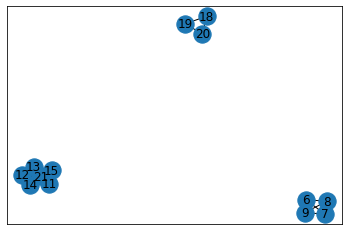

Rule2
Rule3
Rule4
Rule5
{0: {1, 6}, 1: {0, 10, 2}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15, 21}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 12: {2, 13, 14, 15, 21}, 13: {2, 3, 12, 14, 15, 21}, 14: {3, 12, 13, 15, 21}, 15: {2, 3, 12, 13, 14, 21}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 3, 12, 13, 14, 15}}
Inside While


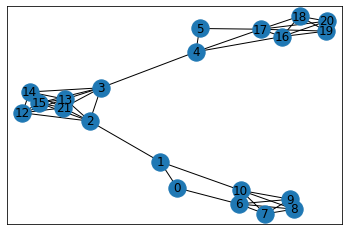

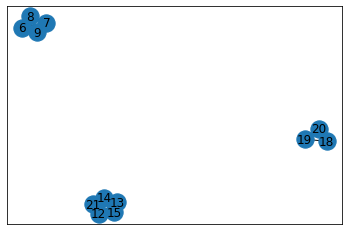

Rule2
Rule3
Rule4
Rule5
Rule6
{0: {1, 6}, 1: {0, 10, 2}, 2: {1, 3, 12, 13}, 3: {2, 4, 14}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 7, 8, 9}, 7: {8, 9, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 8, 9}, 12: {2, 13, 14, 15, 21}, 13: {2, 12, 14, 15, 21}, 14: {3, 12, 13, 15, 21}, 15: {12, 13, 14, 21}, 16: {4, 17, 18, 19}, 17: {4, 5, 16, 20}, 18: {16, 19, 20}, 19: {16, 18, 20}, 20: {17, 18, 19}, 21: {12, 13, 14, 15}}
Inside While


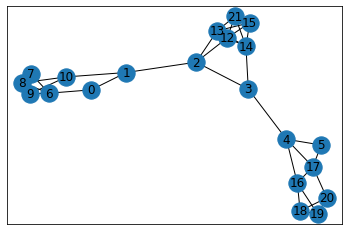

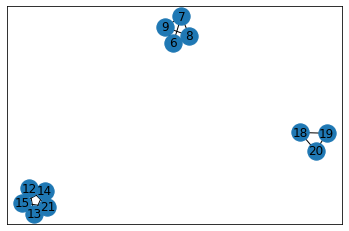

Rule2
Rule3
Rule4
Rule5
{0: {1, 6}, 1: {0, 10, 2}, 2: {1, 3, 12, 13}, 3: {2, 4, 14}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 8, 9}, 8: {9, 10, 6}, 9: {8, 10, 6}, 10: {1, 8, 9}, 12: {2, 13, 14}, 13: {2, 12, 14}, 14: {3, 12, 13}, 16: {4, 17, 18, 19}, 17: {4, 5, 16, 20}, 18: {16, 19, 20}, 19: {16, 18, 20}, 20: {17, 18, 19}}
Inside While


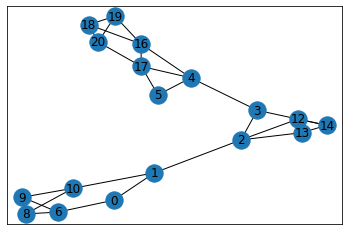

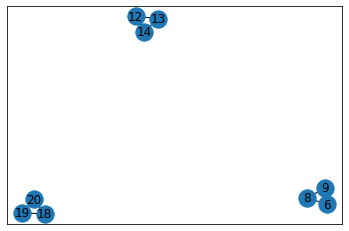

Rule2
Rule3
Rule4
Rule5
Rule6
Rule7
Rule8
{0: {1, 6}, 1: {0, 10, 2}, 2: {1, 3, 12, 13}, 3: {2, 4, 14}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 8, 9}, 8: {9, 10, 6}, 9: {8, 10, 6}, 10: {1, 8, 9}, 12: {2, 13, 14}, 13: {2, 12, 14}, 14: {3, 12, 13}, 16: {4, 17, 18, 19}, 17: {4, 5, 16, 20}, 18: {16, 19, 20}, 19: {16, 18, 20}, 20: {17, 18, 19}}


{0: {1, 6},
 1: {0, 2, 10},
 2: {1, 3, 12, 13},
 3: {2, 4, 14},
 4: {3, 5, 16, 17},
 5: {4, 17},
 6: {0, 8, 9},
 8: {6, 9, 10},
 9: {6, 8, 10},
 10: {1, 8, 9},
 12: {2, 13, 14},
 13: {2, 12, 14},
 14: {3, 12, 13},
 16: {4, 17, 18, 19},
 17: {4, 5, 16, 20},
 18: {16, 19, 20},
 19: {16, 18, 20},
 20: {17, 18, 19}}

In [45]:
mc4.getKernel()

In [46]:
G4.generateFile()

In [47]:
mc4.U

[[0], [1], [10], [4], [5], [16, 17], [2, 3]]

In [48]:
G5 = Graph("graphExample5.txt")
mc5 = matchingCutKernel(G5, cluster3fApprox(G5))

In [49]:
mc5.U

[[0], [1], [10], [2], [3], [4], [5], [17], [16]]

Rule1
{0: {1, 6, 22}, 1: {0, 10, 2, 22}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 11: {12, 13}, 12: {2, 11, 13}, 13: {3, 2, 11, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 22}, 22: {0, 1, 21}}
Rule2
{0: {1, 6, 22}, 1: {0, 10, 2, 22}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 11: {12, 13}, 12: {2, 11, 13}, 13: {3, 2, 11, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 22}, 22: {0, 1, 21}}
Inside While


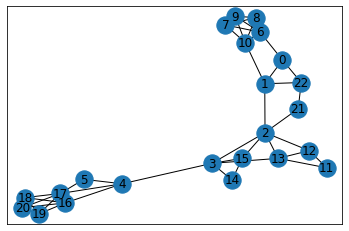

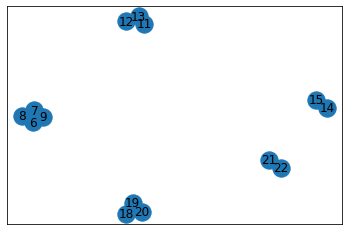

Rule2
Rule3
Rule4
Rule5
{0: {1, 6, 22}, 1: {0, 10, 2, 22}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 22}, 22: {0, 1, 21}}
Inside While


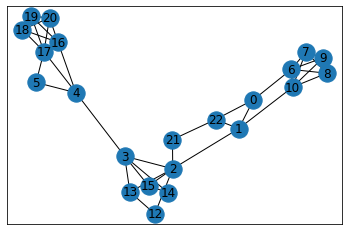

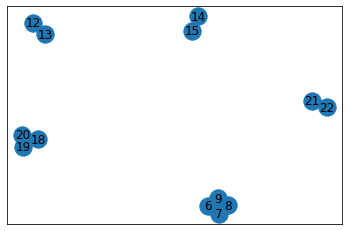

Rule2
Rule3
Rule4
Rule5
Rule6
{0: {1, 6, 22}, 1: {0, 10, 2, 22}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 7, 8, 9}, 7: {8, 9, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 8, 9}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19}, 17: {4, 5, 16, 20}, 18: {16, 19, 20}, 19: {16, 18, 20}, 20: {17, 18, 19}, 21: {2, 22}, 22: {0, 1, 21}}
Inside While


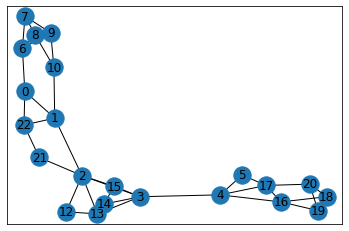

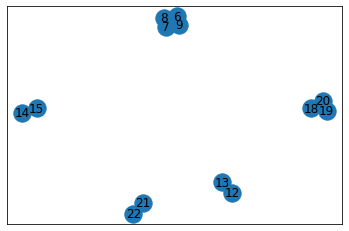

Rule2
Rule3
Rule4
Rule5
{0: {1, 6, 22}, 1: {0, 10, 2, 22}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 8, 9}, 8: {9, 10, 6}, 9: {8, 10, 6}, 10: {1, 8, 9}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19}, 17: {4, 5, 16, 20}, 18: {16, 19, 20}, 19: {16, 18, 20}, 20: {17, 18, 19}, 21: {2, 22}, 22: {0, 1, 21}}
Inside While


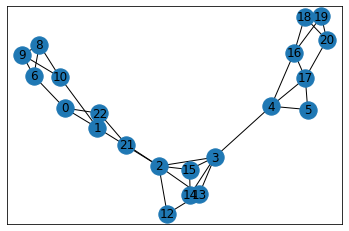

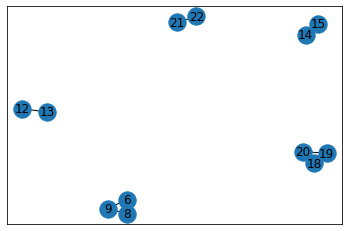

Rule2
Rule3
Rule4
Rule5
Rule6
Rule7
Rule8
{0: {1, 6, 22}, 1: {0, 10, 2, 22}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 8, 9}, 8: {9, 10, 6}, 9: {8, 10, 6}, 10: {1, 8, 9}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19}, 17: {4, 5, 16, 20}, 18: {16, 19, 20}, 19: {16, 18, 20}, 20: {17, 18, 19}, 21: {2, 22}, 22: {0, 1, 21}}


{0: {1, 6, 22},
 1: {0, 2, 10, 22},
 2: {1, 3, 12, 13, 15, 21},
 3: {2, 4, 13, 14, 15},
 4: {3, 5, 16, 17},
 5: {4, 17},
 6: {0, 8, 9},
 8: {6, 9, 10},
 9: {6, 8, 10},
 10: {1, 8, 9},
 12: {2, 13},
 13: {2, 3, 12},
 14: {3, 15},
 15: {2, 3, 14},
 16: {4, 17, 18, 19},
 17: {4, 5, 16, 20},
 18: {16, 19, 20},
 19: {16, 18, 20},
 20: {17, 18, 19},
 21: {2, 22},
 22: {0, 1, 21}}

In [50]:
mc5.getKernel()

In [51]:
mc5.clusters

[{21, 22}, {18, 19, 20}, {14, 15}, {12, 13}, {6, 8, 9}]

In [52]:
G6 = Graph("graphExample6.txt")
mc6 = matchingCutKernel(G6, cluster3fApprox(G6))

In [53]:
mc6.U

[[0], [1], [2], [3], [4], [16], [5], [17], [18]]

Rule1
{0: {1, 23, 6, 22}, 1: {0, 2, 6, 10, 22, 23}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 1, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 11: {12, 13}, 12: {2, 11, 13}, 13: {3, 2, 11, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 22}, 22: {0, 1, 21}, 23: {0, 1}}
Rule2
{0: {1, 23, 6, 22}, 1: {0, 2, 6, 10, 22, 23}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 1, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 11: {12, 13}, 12: {2, 11, 13}, 13: {3, 2, 11, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 22}, 22: {0, 1, 21}, 23: {0, 1}}
Inside While


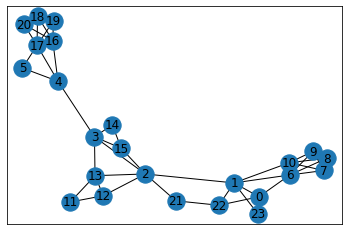

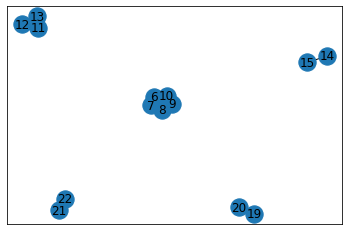

Rule2
Rule3
{0: {1, 23, 6, 22}, 1: {0, 2, 6, 10, 22, 23}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 1, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 11: {12, 13}, 12: {2, 11, 13}, 13: {3, 2, 11, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 22}, 22: {0, 1, 21}, 23: {0, 1}}
Inside While


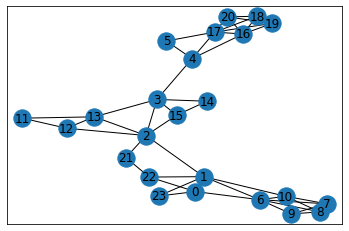

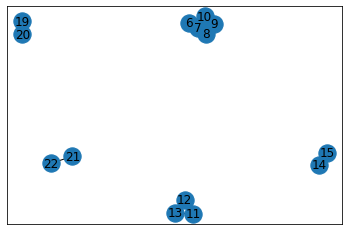

Rule2
Rule3
Rule4
{0: {1, 23, 6, 22}, 1: {0, 2, 6, 10, 22, 23}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 1, 7, 8, 9, 10, 21, 22, 23}, 7: {6, 8, 9, 10, 21, 22, 23}, 8: {6, 7, 9, 10, 21, 22, 23}, 9: {6, 7, 8, 10, 21, 22, 23}, 10: {1, 6, 7, 8, 9, 21, 22, 23}, 11: {12, 13}, 12: {2, 11, 13}, 13: {3, 2, 11, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 6, 7, 8, 9, 10, 22, 23}, 22: {0, 1, 6, 7, 8, 9, 10, 21, 23}, 23: {0, 1, 6, 7, 8, 9, 10, 21, 22}}
Inside While


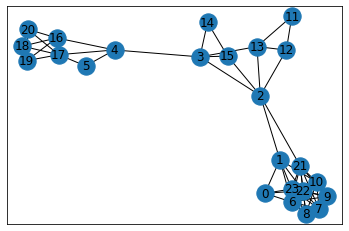

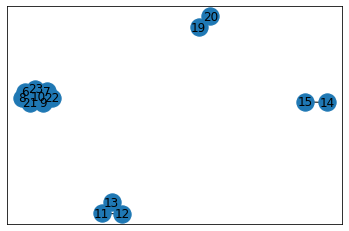

Rule2
Rule3
Rule4
Rule5
{0: {1, 23, 6, 22}, 1: {0, 2, 6, 10, 22, 23}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 1, 10, 21, 22, 23}, 10: {1, 6, 21, 22, 23}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 6, 10, 22, 23}, 22: {0, 1, 6, 10, 21, 23}, 23: {0, 1, 6, 10, 21, 22}}
Inside While


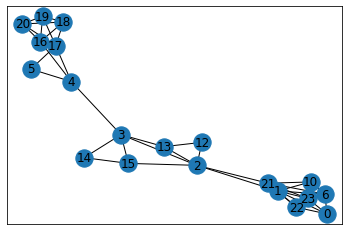

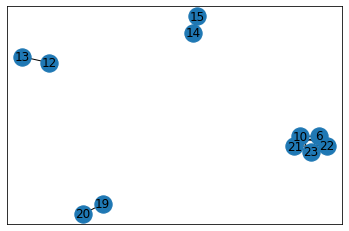

Rule2
Rule3
Rule4
Rule5
Rule6
{0: {1, 6, 10}, 1: {0, 2, 21}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 10, 21, 22, 23}, 10: {0, 6, 21, 22, 23}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 16, 17, 18, 19, 20}, 17: {4, 5, 16, 17, 18, 19, 20}, 18: {16, 17, 18, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {1, 2, 6, 10, 22, 23}, 22: {6, 10, 21, 23}, 23: {6, 10, 21, 22}}
Inside While


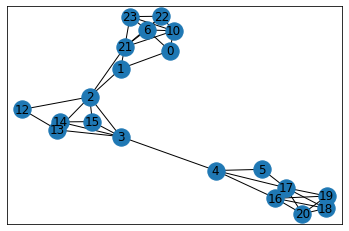

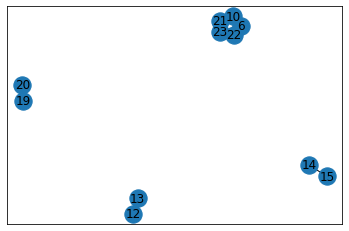

Rule2
Rule3
{0: {1, 6, 10}, 1: {0, 2, 21}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 10, 21, 22, 23}, 10: {0, 6, 21, 22, 23}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 16, 17, 18, 19, 20}, 17: {4, 5, 16, 17, 18, 19, 20}, 18: {16, 17, 18, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {1, 2, 6, 10, 22, 23}, 22: {6, 10, 21, 23}, 23: {6, 10, 21, 22}}
Inside While


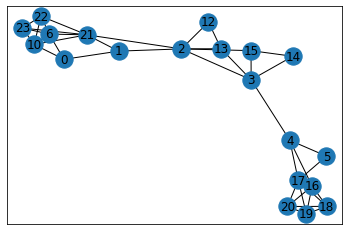

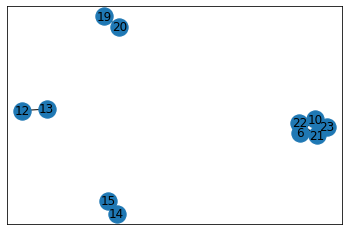

Rule2
Rule3
Rule4
Rule5
{0: {1, 6, 10}, 1: {0, 2, 21}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 4}, 6: {0, 10, 21}, 10: {0, 6, 21}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 16, 17, 18, 19, 20}, 17: {4, 5, 16, 17, 18, 19, 20}, 18: {16, 17, 18, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {1, 2, 6, 10}}
Inside While


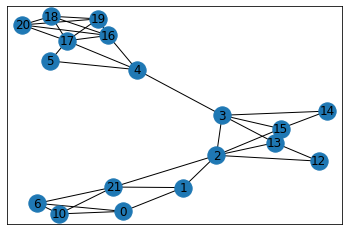

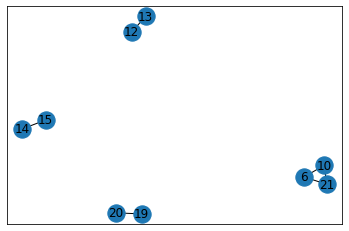

Rule2
Rule3
Rule4
Rule5
Rule6
{0: {1, 6, 10}, 1: {0, 2, 21}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {3, 4, 5, 16, 17, 18}, 5: {17, 4}, 6: {0, 10, 21}, 10: {0, 6, 21}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 16, 17, 18, 19, 20}, 17: {4, 5, 16, 17, 18, 19, 20}, 18: {4, 16, 17, 18, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {1, 2, 6, 10}}
Inside While


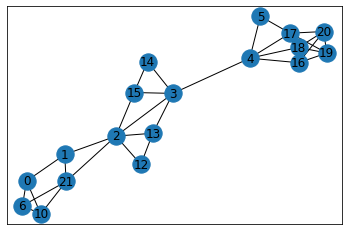

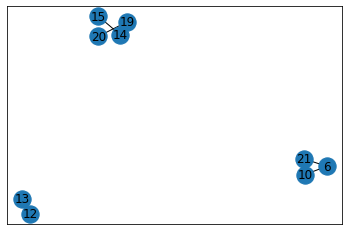

Rule2
Rule3
Rule4
Rule5
Rule6
Rule7
Rule8
{0: {1, 6, 10}, 1: {0, 2, 21}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {3, 4, 5, 16, 17, 18}, 5: {17, 4}, 6: {0, 10, 21}, 10: {0, 6, 21}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 16, 17, 18, 19, 20}, 17: {4, 5, 16, 17, 18, 19, 20}, 18: {4, 16, 17, 18, 19, 20}, 19: {16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {1, 2, 6, 10}}


{0: {1, 6, 10},
 1: {0, 2, 21},
 2: {1, 3, 12, 13, 15, 21},
 3: {2, 4, 13, 14, 15},
 4: {3, 4, 5, 16, 17, 18},
 5: {4, 17},
 6: {0, 10, 21},
 10: {0, 6, 21},
 12: {2, 13},
 13: {2, 3, 12},
 14: {3, 15},
 15: {2, 3, 14},
 16: {4, 16, 17, 18, 19, 20},
 17: {4, 5, 16, 17, 18, 19, 20},
 18: {4, 16, 17, 18, 19, 20},
 19: {16, 17, 18, 20},
 20: {16, 17, 18, 19},
 21: {1, 2, 6, 10}}

In [54]:
mc6.getKernel()

In [55]:
mc6.clusters

[{6, 10, 21}, {19, 20}, {14, 15}, {12, 13}]

In [56]:
G7 = Graph("graphExample7.txt")
mc7 = matchingCutKernel(G7, cluster3fApprox(G7))

In [57]:
mc7.U

[[0], [1], [2], [3], [4], [16], [5], [17], [18]]

Rule1
{0: {1, 23, 6, 22}, 1: {0, 2, 6, 10, 22, 23}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 19, 4}, 6: {0, 1, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 11: {12, 13}, 12: {2, 11, 13}, 13: {3, 2, 11, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {5, 16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 22}, 22: {0, 1, 21}, 23: {0, 1}}
Rule2
{0: {1, 23, 6, 22}, 1: {0, 2, 6, 10, 22, 23}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 19, 4}, 6: {0, 1, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 11: {12, 13}, 12: {2, 11, 13}, 13: {3, 2, 11, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {5, 16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 22}, 22: {0, 1, 21}, 23: {0, 1}}
Inside While


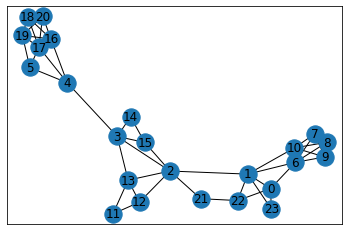

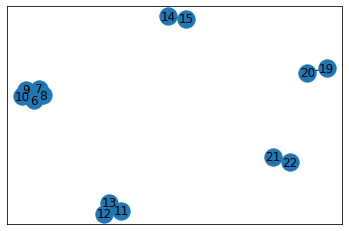

Rule2
Rule3
{0: {1, 23, 6, 22}, 1: {0, 2, 6, 10, 22, 23}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 19, 4}, 6: {0, 1, 7, 8, 9, 10}, 7: {8, 9, 10, 6}, 8: {9, 10, 6, 7}, 9: {8, 10, 6, 7}, 10: {1, 6, 7, 8, 9}, 11: {12, 13}, 12: {2, 11, 13}, 13: {3, 2, 11, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {5, 16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 22}, 22: {0, 1, 21}, 23: {0, 1}}
Inside While


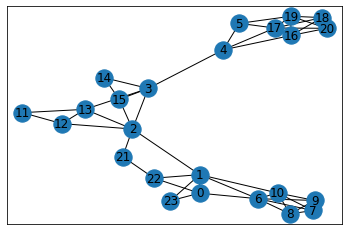

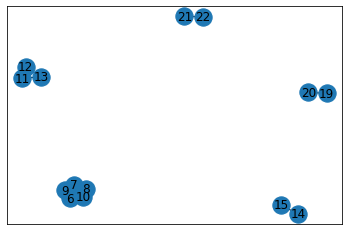

Rule2
Rule3
Rule4
{0: {1, 23, 6, 22}, 1: {0, 2, 6, 10, 22, 23}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 19, 4}, 6: {0, 1, 7, 8, 9, 10, 21, 22, 23}, 7: {6, 8, 9, 10, 21, 22, 23}, 8: {6, 7, 9, 10, 21, 22, 23}, 9: {6, 7, 8, 10, 21, 22, 23}, 10: {1, 6, 7, 8, 9, 21, 22, 23}, 11: {12, 13}, 12: {2, 11, 13}, 13: {3, 2, 11, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {5, 16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 6, 7, 8, 9, 10, 22, 23}, 22: {0, 1, 6, 7, 8, 9, 10, 21, 23}, 23: {0, 1, 6, 7, 8, 9, 10, 21, 22}}
Inside While


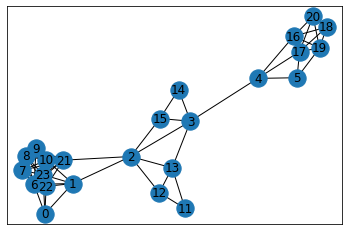

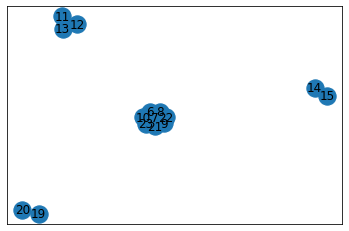

Rule2
Rule3
Rule4
Rule5
{0: {1, 23, 6, 22}, 1: {0, 2, 6, 10, 22, 23}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {17, 19, 4}, 6: {0, 1, 10, 21, 22, 23}, 10: {1, 6, 21, 22, 23}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 17, 18, 19, 20}, 17: {4, 5, 16, 18, 19, 20}, 18: {16, 17, 19, 20}, 19: {5, 16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {2, 6, 10, 22, 23}, 22: {0, 1, 6, 10, 21, 23}, 23: {0, 1, 6, 10, 21, 22}}
Inside While


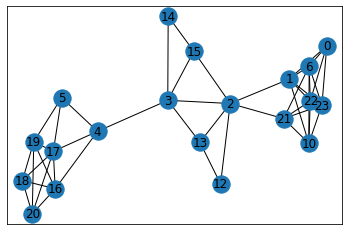

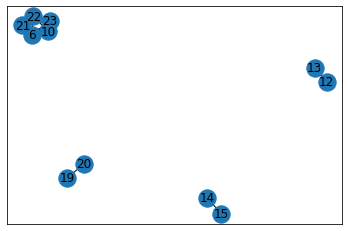

Rule2
Rule3
Rule4
Rule5
Rule6
{0: {1, 6, 10}, 1: {0, 2, 21}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {4, 5, 16, 17, 18, 19}, 6: {0, 10, 21, 22, 23}, 10: {0, 6, 21, 22, 23}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 5, 16, 17, 18, 19, 20}, 17: {4, 5, 16, 17, 18, 19, 20}, 18: {5, 16, 17, 18, 19, 20}, 19: {5, 16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {1, 2, 6, 10, 22, 23}, 22: {6, 10, 21, 23}, 23: {6, 10, 21, 22}}
Inside While


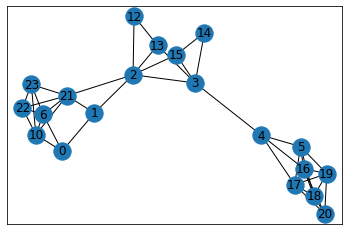

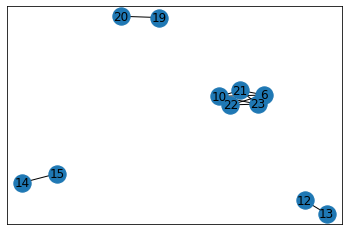

Rule2
Rule3
{0: {1, 6, 10}, 1: {0, 2, 21}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {4, 5, 16, 17, 18, 19}, 6: {0, 10, 21, 22, 23}, 10: {0, 6, 21, 22, 23}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 5, 16, 17, 18, 19, 20}, 17: {4, 5, 16, 17, 18, 19, 20}, 18: {5, 16, 17, 18, 19, 20}, 19: {5, 16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {1, 2, 6, 10, 22, 23}, 22: {6, 10, 21, 23}, 23: {6, 10, 21, 22}}
Inside While


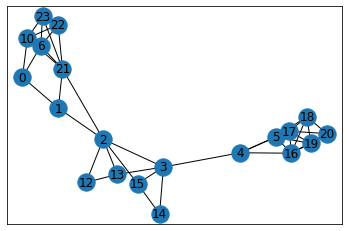

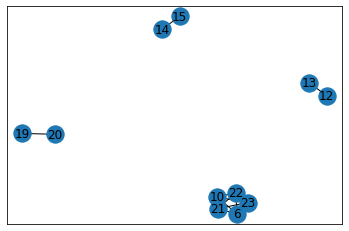

Rule2
Rule3
Rule4
Rule5
{0: {1, 6, 10}, 1: {0, 2, 21}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {16, 17, 3, 5}, 5: {4, 5, 16, 17, 18, 19}, 6: {0, 10, 21}, 10: {0, 6, 21}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 5, 16, 17, 18, 19, 20}, 17: {4, 5, 16, 17, 18, 19, 20}, 18: {5, 16, 17, 18, 19, 20}, 19: {5, 16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {1, 2, 6, 10}}
Inside While


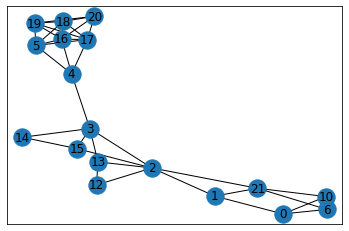

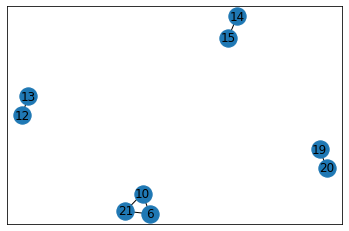

Rule2
Rule3
Rule4
Rule5
Rule6
{0: {1, 6, 10}, 1: {0, 2, 21}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {3, 4, 5, 16, 17, 18}, 5: {4, 5, 16, 17, 18, 19}, 6: {0, 10, 21}, 10: {0, 6, 21}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 5, 16, 17, 18, 19, 20}, 17: {4, 5, 16, 17, 18, 19, 20}, 18: {4, 5, 16, 17, 18, 19, 20}, 19: {5, 16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {1, 2, 6, 10}}
Inside While


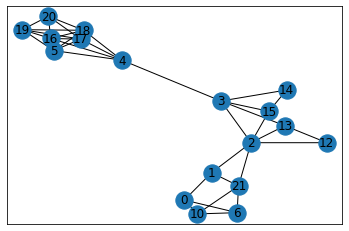

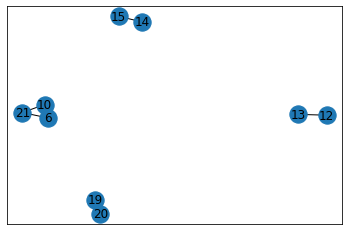

Rule2
Rule3
Rule4
Rule5
Rule6
Rule7
Rule8
{0: {1, 6, 10}, 1: {0, 2, 21}, 2: {1, 3, 12, 13, 15, 21}, 3: {2, 4, 13, 14, 15}, 4: {3, 4, 5, 16, 17, 18}, 5: {4, 5, 16, 17, 18, 19}, 6: {0, 10, 21}, 10: {0, 6, 21}, 12: {2, 13}, 13: {3, 2, 12}, 14: {3, 15}, 15: {2, 3, 14}, 16: {4, 5, 16, 17, 18, 19, 20}, 17: {4, 5, 16, 17, 18, 19, 20}, 18: {4, 5, 16, 17, 18, 19, 20}, 19: {5, 16, 17, 18, 20}, 20: {16, 17, 18, 19}, 21: {1, 2, 6, 10}}


{0: {1, 6, 10},
 1: {0, 2, 21},
 2: {1, 3, 12, 13, 15, 21},
 3: {2, 4, 13, 14, 15},
 4: {3, 4, 5, 16, 17, 18},
 5: {4, 5, 16, 17, 18, 19},
 6: {0, 10, 21},
 10: {0, 6, 21},
 12: {2, 13},
 13: {2, 3, 12},
 14: {3, 15},
 15: {2, 3, 14},
 16: {4, 5, 16, 17, 18, 19, 20},
 17: {4, 5, 16, 17, 18, 19, 20},
 18: {4, 5, 16, 17, 18, 19, 20},
 19: {5, 16, 17, 18, 20},
 20: {16, 17, 18, 19},
 21: {1, 2, 6, 10}}

In [58]:
mc7.getKernel()

In [59]:
mc7.clusters

[{6, 10, 21}, {19, 20}, {14, 15}, {12, 13}]

In [60]:
mc7.G.generateFile()

In [61]:
mc7.U

[[2], [3], [0, 1], [4, 5, 18, 16, 17]]

In [62]:
G8 = Graph("graphExample8.txt")
mc8 = matchingCutKernel(G8, cluster3fApprox(G8))

In [63]:
mc8.w.findClusters()

[{6, 7}]

In [64]:
mc8.U

[[0], [1], [2], [3], [4], [5]]

Rule1
{0: {1, 3, 4, 5, 7}, 1: {0, 2, 3, 4, 5, 7}, 2: {1, 3, 6}, 3: {0, 1, 2, 4}, 4: {0, 1, 3, 5}, 5: {0, 1, 4}, 6: {2, 7}, 7: {0, 1, 6}}
Rule2
Rule3
{0: {1, 3, 4, 5, 7}, 1: {0, 2, 3, 4, 5, 7}, 2: {1, 3, 6}, 3: {0, 1, 2, 4}, 4: {0, 1, 3, 5}, 5: {0, 1, 4}, 6: {2, 7}, 7: {0, 1, 6}}
Inside While


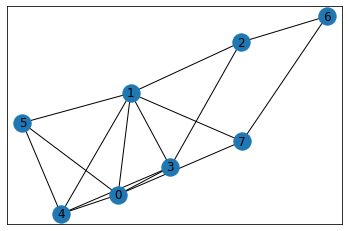

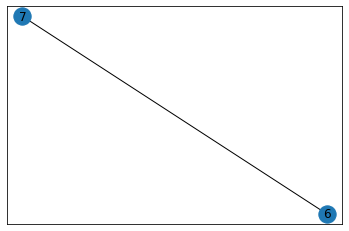

Rule2
Rule3
Rule4
Rule5
Rule6
{0: {0, 1, 3, 4, 5, 7}, 1: {0, 1, 2, 3, 4, 5, 7}, 2: {1, 3, 6}, 3: {0, 1, 2, 3, 4, 5}, 4: {0, 1, 3, 4, 5}, 5: {0, 1, 3, 4, 5}, 6: {2, 7}, 7: {0, 1, 6}}
Inside While


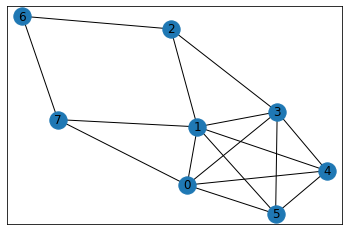

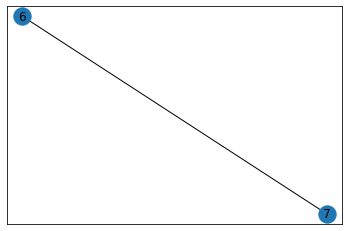

Rule2
Rule3
Rule4
Rule5
Rule6
Rule7
{0: {0, 1, 3, 4, 5}, 1: {0, 1, 2, 3, 4, 5}, 2: {1, 3}, 3: {0, 1, 2, 3, 4, 5}, 4: {0, 1, 3, 4, 5}, 5: {0, 1, 3, 4, 5}}
Inside While


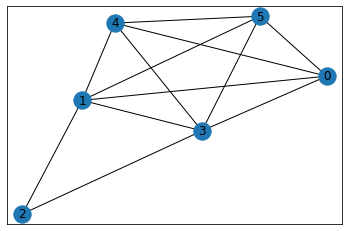

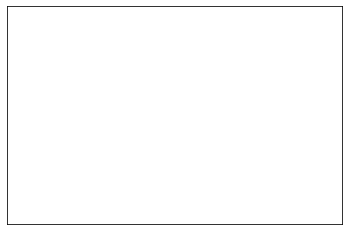

Rule2
Rule3
Rule4
Rule5
Rule6
Rule7
Rule8
{0: {0, 1, 3, 4, 5}, 1: {0, 1, 2, 3, 4, 5}, 2: {1, 3}, 3: {0, 1, 2, 3, 4, 5}, 4: {0, 1, 3, 4, 5}, 5: {0, 1, 3, 4, 5}}


{0: {0, 1, 3, 4, 5},
 1: {0, 1, 2, 3, 4, 5},
 2: {1, 3},
 3: {0, 1, 2, 3, 4, 5},
 4: {0, 1, 3, 4, 5},
 5: {0, 1, 3, 4, 5}}

In [65]:
mc8.getKernel()

In [66]:
mc8.clusters

[]

In [67]:
G9 = Graph("graphExample9.txt")
mc9 = matchingCutKernel(G9, cluster3fApprox(G9))

In [68]:
mc9.w.findClusters()

[{12, 13, 14}, {9, 10, 11}, {6, 7, 8}]

In [69]:
mc9.U

[[0], [1], [2], [3], [4], [5]]

Rule1
{0: {1, 6, 7}, 1: {0, 2, 6, 7}, 2: {11, 1, 3, 9}, 3: {2, 4, 7, 9, 11, 14}, 4: {3, 5, 8, 11, 13, 14}, 5: {4, 13, 14}, 6: {8, 0, 1, 7}, 7: {0, 1, 3, 6, 8}, 8: {4, 6, 7}, 9: {2, 3, 10, 11}, 10: {9, 11}, 11: {2, 3, 4, 9, 10}, 12: {13, 14}, 13: {5, 12, 4, 14}, 14: {3, 4, 5, 12, 13}}
Rule2
{0: {1, 6, 7}, 1: {0, 2, 6, 7}, 2: {11, 1, 3, 9}, 3: {2, 4, 7, 9, 11, 14}, 4: {3, 5, 8, 11, 13, 14}, 5: {4, 13, 14}, 6: {8, 0, 1, 7}, 7: {0, 1, 3, 6, 8}, 8: {4, 6, 7}, 9: {2, 3, 10, 11}, 10: {9, 11}, 11: {2, 3, 4, 9, 10}, 12: {13, 14}, 13: {5, 12, 4, 14}, 14: {3, 4, 5, 12, 13}}
Inside While


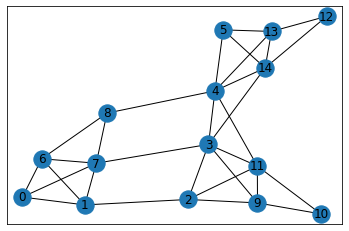

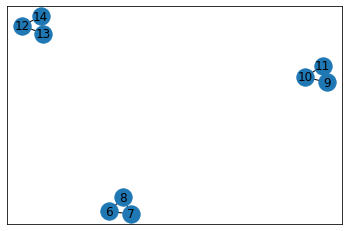

Rule2
Rule3
Rule4
Rule5
{0: {1, 6, 7}, 1: {0, 2, 6, 7}, 2: {11, 1, 3, 9}, 3: {2, 4, 7, 9, 11, 14}, 4: {3, 5, 8, 11, 13, 14}, 5: {4, 13, 14}, 6: {8, 0, 1, 7}, 7: {0, 1, 3, 6, 8}, 8: {4, 6, 7}, 9: {2, 3, 11}, 11: {2, 3, 4, 9}, 13: {5, 4, 14}, 14: {3, 4, 5, 13}}
Inside While


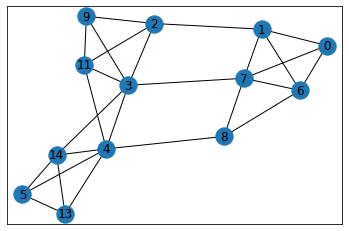

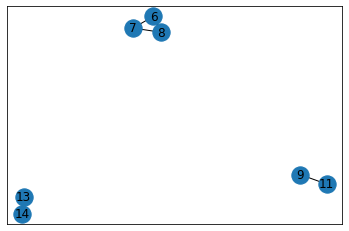

Rule2
Rule3
Rule4
Rule5
Rule6
{0: {8, 1, 6}, 1: {0, 2, 7}, 2: {11, 1, 3, 9}, 3: {2, 4, 7, 9, 11, 14}, 4: {3, 5, 8, 11, 13, 14}, 5: {4, 13, 14}, 6: {8, 0, 7}, 7: {1, 3, 6, 8}, 8: {0, 4, 6, 7}, 9: {2, 3, 11}, 11: {2, 3, 4, 9}, 13: {5, 4, 14}, 14: {3, 4, 5, 13}}
Inside While


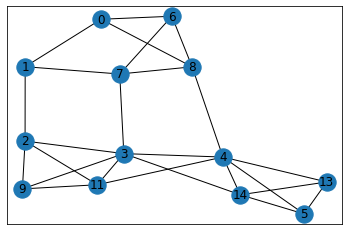

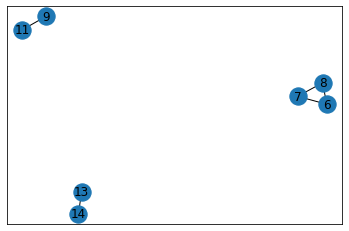

Rule2
Rule3
Rule4
Rule5
Rule6
Rule7
Rule8
{0: {8, 1, 6}, 1: {0, 2, 7}, 2: {11, 1, 3, 9}, 3: {2, 4, 7, 9, 11, 14}, 4: {3, 5, 8, 11, 13, 14}, 5: {4, 13, 14}, 6: {8, 0, 7}, 7: {1, 3, 6, 8}, 8: {0, 4, 6, 7}, 9: {2, 3, 11}, 11: {2, 3, 4, 9}, 13: {5, 4, 14}, 14: {3, 4, 5, 13}}
Inside While


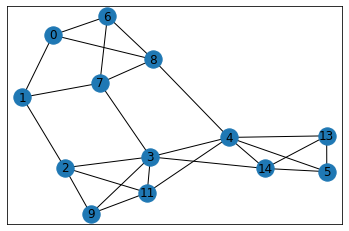

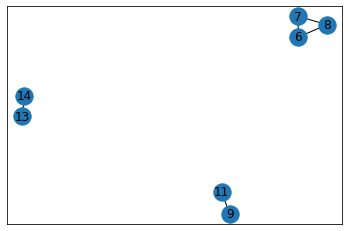

Rule2
Rule3
Rule4
{0: {8, 1, 6}, 1: {0, 2, 7}, 2: {11, 1, 3, 9}, 3: {2, 4, 7, 9, 11, 14}, 4: {3, 5, 8, 11, 13, 14}, 5: {4, 13, 14}, 6: {8, 0, 7}, 7: {1, 3, 6, 8}, 8: {0, 4, 6, 7}, 9: {2, 3, 11, 13, 14}, 11: {2, 3, 4, 9, 13, 14}, 13: {4, 5, 9, 11, 14}, 14: {3, 4, 5, 9, 11, 13}}
Inside While


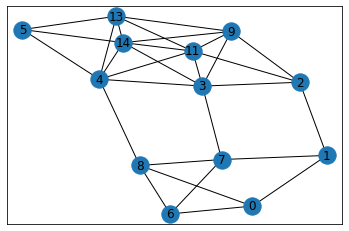

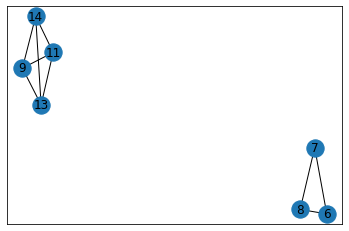

Rule2
Rule3
Rule4
Rule5
Rule6
{0: {8, 1, 6}, 1: {0, 2, 7}, 2: {1, 2, 3, 4, 5}, 3: {2, 3, 4, 5, 7}, 4: {2, 3, 4, 5, 8, 9, 11}, 5: {2, 3, 4, 5}, 6: {8, 0, 7}, 7: {1, 3, 6, 8}, 8: {0, 4, 6, 7}, 9: {4, 11, 13, 14}, 11: {4, 9, 13, 14}, 13: {9, 11, 14}, 14: {9, 11, 13}}
Inside While


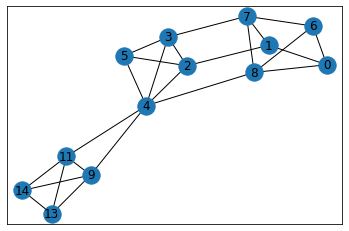

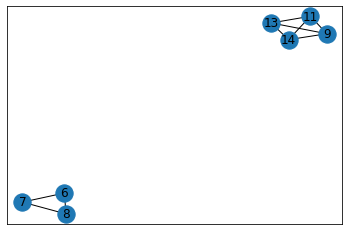

Rule2
Rule3
Rule4
Rule5
{0: {8, 1, 6}, 1: {0, 2, 7}, 2: {1, 2, 3, 4, 5}, 3: {2, 3, 4, 5, 7}, 4: {2, 3, 4, 5, 8, 9, 11}, 5: {2, 3, 4, 5}, 6: {8, 0, 7}, 7: {1, 3, 6, 8}, 8: {0, 4, 6, 7}, 9: {4, 11}, 11: {4, 9}}
Inside While


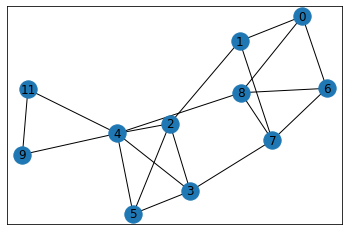

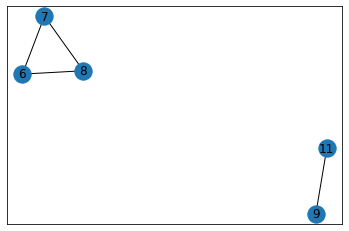

Rule2
Rule3
Rule4
Rule5
Rule6
Rule7
Rule8
{0: {8, 1, 6}, 1: {0, 2, 7}, 2: {1, 2, 3, 4, 5}, 3: {2, 3, 4, 5, 7}, 4: {2, 3, 4, 5, 8, 9, 11}, 5: {2, 3, 4, 5}, 6: {8, 0, 7}, 7: {1, 3, 6, 8}, 8: {0, 4, 6, 7}, 9: {4, 11}, 11: {4, 9}}


{0: {1, 6, 8},
 1: {0, 2, 7},
 2: {1, 2, 3, 4, 5},
 3: {2, 3, 4, 5, 7},
 4: {2, 3, 4, 5, 8, 9, 11},
 5: {2, 3, 4, 5},
 6: {0, 7, 8},
 7: {1, 3, 6, 8},
 8: {0, 4, 6, 7},
 9: {4, 11},
 11: {4, 9}}

In [70]:
mc9.getKernel()

In [71]:
mc9.clusters

[{9, 11}, {6, 7, 8}]